In [1]:
from urllib import parse
import re
import types
import warnings

import upsetplot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
from publicsuffixlist import PublicSuffixList
from apyori import apriori
from sklearn.preprocessing import MultiLabelBinarizer

try:
    INPUT_FILES = snakemake.input
    OUTPUT_FILES = snakemake.output
except NameError:
    INPUT_FILES = None
    OUTPUT_FILES = None

In [2]:
if INPUT_FILES is None:
    dataset = pd.read_csv(f'../results/profile-domains/profile-results.csv.gz')
else:
    dataset = pd.read_csv(INPUT_FILES.profiled_dataset)

dataset

,domain,fetch_duration,status,url,real_url,alt_svc,server,error,error_str
0,fasleaval.com,1.566932,200.0,https://fasleaval.com,https://fasleaval.com,"quic="":443""; ma=2592000; v=""43,46"", h3-Q043="":...",NaN,NaN,NaN
1,danialwebrp.blogfa.com,30.433166,NaN,NaN,NaN,NaN,NaN,timeout,NaN
2,balajiflexipack.in,3.341826,200.0,https://www.balajiflexipack.in/,https://www.balajiflexipack.in/,NaN,openresty/1.13.6.2,NaN,NaN
3,awrad.org,1.535363,200.0,http://www.awrad.org/,http://www.awrad.org/,NaN,Apache,NaN,NaN
4,k-middleton.com,1.314125,200.0,https://k-middleton.com,https://k-middleton.com,NaN,nginx/1.16.1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2111028,slog.wiwide.com,0.972838,200.0,https://slog.wiwide.com,https://slog.wiwide.com,NaN,nginx,NaN,NaN
2111029,proxy-12.sg1.dailymotion.com,0.793117,404.0,https://proxy-12.sg1.dailymotion.com,https://proxy-12.sg1.dailymotion.com,NaN,lumberjack/2.4.19-2.4.19,NaN,NaN
2111030,ktm-lc4.net,0.375445,200.0,https://www.ktm-lc4.net/,https://www.ktm-lc4.net/,NaN,Apache,NaN,NaN
2111031,idownloadringtones.info,0.621730,200.0,https://idownloadringtones.info,https://idownloadringtones.info,NaN,cloudflare,NaN,NaN


In [3]:
def renamer(label):
    for tag in ["Microsoft-IIS", "nginx", "Apache", "openresty"]:
        if tag in label:
            return tag
    return label

test = dataset.iloc[:, 0:7]
test["quic_support"] = test["alt_svc"].str.contains("quic").fillna(False)
# TODO: Chekc how many did not return a server name
test = test[~test["server"].isna()][["quic_support", "server"]].set_index("server")
test = test.rename(renamer, axis=0)

n_servers = test.groupby(["quic_support", "server"]).size()
# n_servers = n_servers[n_servers > 1000].to_frame()
n_servers = n_servers.unstack(level="quic_support")
n_servers["total"] = n_servers[False] + n_servers[True]

n_servers.fillna(0).sort_values(by="total", ascending=False).head(30)



quic_support,False,True,total
server,,,
Apache,278612.0,46.0,278658.0
nginx,237295.0,8706.0,246001.0
cloudflare,223855.0,1.0,223856.0
LiteSpeed,6111.0,38211.0,44322.0
Microsoft-IIS,37222.0,16.0,37238.0
openresty,22490.0,6.0,22496.0
GSE,3454.0,11443.0,14897.0
AmazonS3,13860.0,112.0,13972.0
Tengine,6791.0,19.0,6810.0


Library Error    1013026
200               940657
400               139366
500                17648
300                  154
600                  134
1000                  34
700                    9
800                    2
100                    2
900                    1
Name: status, dtype: int64

/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jsmith/Projects/quic-traffic-analysis/env

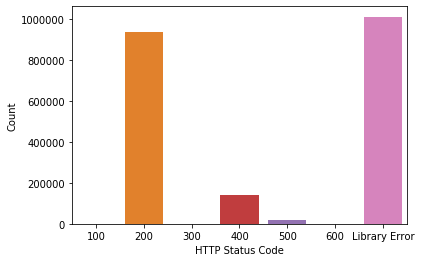

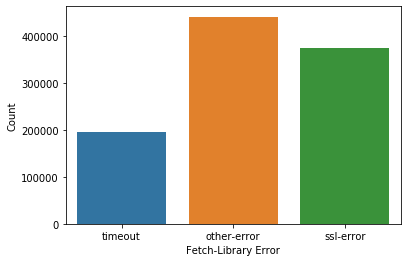

In [4]:
def plot_errors(frame):
    figure, axes = plt.subplots()
    plot_data = np.around(dataset['status'], -2).fillna(0).astype(int).replace({0: "Library Error"})
    display(plot_data.value_counts())
    sns.countplot(plot_data, order = [100, 200, 300, 400, 500, 600, "Library Error"], ax=axes)
    axes.set_xlabel("HTTP Status Code")
    axes.set_ylabel("Count")
    figure.show()
    if OUTPUT_FILES is not None:
        figure.savefig(OUTPUT_FILES.http_status_plot, bbox_inches='tight', dpi=150)
    
    figure, axes = plt.subplots()
    axes = sns.countplot(dataset['error'])
    axes.set_xlabel("Fetch-Library Error")
    axes.set_ylabel("Count")
    figure.show()
    if OUTPUT_FILES is not None:
        figure.savefig(OUTPUT_FILES.error_plot, bbox_inches='tight', dpi=150)
    
plot_errors(dataset)

In [5]:
def ensure_unique_alt_svc(frame, tolerance = 0):
    """Ensure that each group of netloc has the same alt_svc 
    specification.

    Up to tolerance net locations are allowed to violate this, but a
    warning is issued. 
    """
    counts = frame.groupby('netloc').agg({'alt_svc': 'nunique'}).squeeze()
    is_violating = counts > 1
    print(sum(is_violating))
    assert sum(is_violating) <= tolerance
    
    if is_violating.any():
        violations = counts[is_violating].index
        for name, group in frame[frame['netloc'].isin(violations)].groupby('netloc'):
            records = set(group['alt_svc'])
            warnings.warn(f"Domain {name} has multiple alt-svc records: {records}")
    

def filter_invalid_entries(frame):
    """Perform filtering to remove invalid or uninteresting results.
    
    Note that issues such as www.google.com and google.com are already
    resolved as we consider only the final redirected url.
    """
    # Only responses with an HTTP200 result
    frame = frame[frame['status'] == 200]
    
    # Only responses with a QUIC or HTTP3 in the alt-svc
    alt_svc = frame['alt_svc']
    frame = frame[alt_svc.notna() & (alt_svc.str.contains('quic') | alt_svc.str.contains('h3'))]
    
    # Remove any "accounts.google.com" entries, as these are concerning
    frame = frame[~frame['url'].str.contains('accounts.google.com')]
    
    # Add the network location to frame, as this ignores things such as trailing / or query parameters which may be present in the redirect
    frame['netloc'] = frame['url'].apply(lambda x: parse.urlparse(x).netloc)
    # Remove any ports from the net location
    frame['netloc'] = frame['netloc'].str.replace(':\d+', '')
    
    # Filter to a single alt-svc record per network location
    frame = frame[['url', 'netloc', 'alt_svc', 'server']]
    ensure_unique_alt_svc(frame, tolerance = 40)
    frame = frame.groupby('netloc', group_keys=False).apply(lambda x: x.head(1) if len(x) > 1 else x)
    
    
    return frame
    
valid_results = filter_invalid_entries(dataset)
valid_results

39


/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Domain angrybirds-facebook.appspot.com has multiple alt-svc records: {'h3-28=":443"; ma=2592000,h3-27=":443"; ma=2592000,h3-25=":443"; ma=2592000,h3-T050=":443"; ma=2592000,h3-Q050=":443"; ma=2592000,h3-Q049=":443"; ma=2592000,h3-Q048=":443"; ma=2592000,h3-Q046=":443"; ma=2592000,h3-Q043=":443"; ma=2592000,quic=":443"; ma=2592000; v="46,43"', 'h3-27=":443"; ma=2592000,h3-25=":443"; ma=2592000,h3-T050=":443"; ma=2592000,h3-Q050=":443"; ma=2592000,h3-Q046=":443"; ma=2592000,h3-Q043=":443"; ma=2592000,quic=":443"; ma=2592000; v="46,43"'}
/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Domain area120.google.com has multiple alt-svc records: {'h3-28=":443"; ma=2592000,h3-27=":443"; ma=2592000,h3-25=":443"; ma=2592000,h3-T050=":443"; ma=2592000,h3-Q050=":443"; ma=2592000,h3-Q049=":443"; ma=2592000,h3-Q048=":443";

,url,netloc,alt_svc,server
900690,https://0-6.no,0-6.no,"h3-27="":443""; ma=86400, h3-28="":443""; ma=86400...",cloudflare
255563,https://0-biz.co.il,0-biz.co.il,"quic="":443""; ma=2592000; v=""43,46"", h3-Q043="":...",LiteSpeed
1257298,https://001122334455667788.blogspot.com,001122334455667788.blogspot.com,"h3-28="":443""; ma=2592000,h3-27="":443""; ma=2592...",GSE
2064163,https://007store.com,007store.com,"h3-27="":443""; ma=86400, h3-28="":443""; ma=86400...",cloudflare
18714,https://01estore.com,01estore.com,"quic="":443""; ma=2592000; v=""43,46"", h3-Q043="":...",NaN
...,...,...,...,...
1087376,https://zytronic.co.uk,zytronic.co.uk,"quic="":443""; ma=2592000; v=""43,46"", h3-Q043="":...",LiteSpeed
1700101,https://zzibasho.ir,zzibasho.ir,"quic="":443""; ma=2592000; v=""43,46"", h3-Q043="":...",NaN
606043,https://zzperformance.com,zzperformance.com,"h3-27="":443""; ma=86400, h3-28="":443""; ma=86400...",cloudflare
2056826,https://zzyshani.blogspot.com,zzyshani.blogspot.com,"h3-28="":443""; ma=2592000,h3-27="":443""; ma=2592...",GSE


In [6]:
def remove_similar_roots(frame):
    """Remove domains which only differ in the public suffix.
    
    We prefer the '.com', '.net', or '.org' domain in a group, but if
    not present we return a randomly selected domain.
    
    We note that mail.ch and mail.co.uk may be entirely different
    domain. However, given the fact that many domains have different 
    localisations of their domain with differing public suffixes, we
    opt to simply remove all such occurences.
    """
    def _select_domain(group):
        if len(group) == 1:
            return group
        
        for common_tld in ('com', 'net', 'org'):
            if (group['public_sfx'] == common_tld).any():
                return group[group['public_sfx'] == common_tld]
        return group.sample(n=1)
    
    psl = PublicSuffixList()

    frame.loc[:, 'public_sfx'] = frame['netloc'].apply(lambda x: psl.publicsuffix(x))
    frame.loc[:, 'public_sfx_len'] = frame['netloc'].apply(lambda x: len(psl.publicsuffix(x)))
    frame.loc[:, 'public_root'] = frame.apply(lambda x: x['netloc'][:-(x['public_sfx_len'] + 1)], axis=1)
    
    frame = frame.groupby('public_root', group_keys=False).apply(_select_domain)
    return frame[['url', 'netloc', 'alt_svc']].reset_index(drop=True)
    
unique_domains = remove_similar_roots(valid_results)
unique_domains

,url,netloc,alt_svc
0,https://0-6.no,0-6.no,"h3-27="":443""; ma=86400, h3-28="":443""; ma=86400..."
1,https://0-biz.co.il,0-biz.co.il,"quic="":443""; ma=2592000; v=""43,46"", h3-Q043="":..."
2,https://001122334455667788.blogspot.com,001122334455667788.blogspot.com,"h3-28="":443""; ma=2592000,h3-27="":443""; ma=2592..."
3,https://007store.com,007store.com,"h3-27="":443""; ma=86400, h3-28="":443""; ma=86400..."
4,https://01estore.com,01estore.com,"quic="":443""; ma=2592000; v=""43,46"", h3-Q043="":..."
...,...,...,...
94999,https://zytronic.co.uk,zytronic.co.uk,"quic="":443""; ma=2592000; v=""43,46"", h3-Q043="":..."
95000,https://zzibasho.ir,zzibasho.ir,"quic="":443""; ma=2592000; v=""43,46"", h3-Q043="":..."
95001,https://zzperformance.com,zzperformance.com,"h3-27="":443""; ma=86400, h3-28="":443""; ma=86400..."
95002,https://zzyshani.blogspot.com,zzyshani.blogspot.com,"h3-28="":443""; ma=2592000,h3-27="":443""; ma=2592..."


In [7]:
def reduce_representation(frame, sld_domains, whitelist: str = '(com|co|org|ac)\..*', threshold: int = 100):
    """Reduce the representation of the specified sld_domains 
    second-level domains to within the threshold.
    
    Any domains which are still not within the threshold, but are not
    excluded by the whitelist will result in an error.
    
    Return the index of the reduced sample.
    """
    assert frame.index.is_unique
    
    frame['2LD'] =  frame['netloc'].str.split('.').apply(lambda x: '.'.join(x[-2:]))
    whitelist_mask = frame['2LD'].str.match(whitelist)
    exceptions_mask =  whitelist_mask | ~frame['2LD'].isin(sld_domains)
    
    # Check that there are no others over the threshold when only considering the whitelist
    non_filtered = (frame[~whitelist_mask & ~frame['2LD'].isin(sld_domains)]
                    ['2LD']
                    .value_counts())
    if (non_filtered > threshold).any():
        unaccounted = non_filtered[non_filtered > threshold].to_dict()
        raise ValueError(f"The provided sld_domains ({sld_domains}) and "
                         f"whitelist ({whitelist}) did not account for all "
                         f"excessive domains: {unaccounted}.")
    
    # Now perform the downsampling
    samples_idx = (frame[~exceptions_mask]
                   .groupby('2LD', group_keys=False)
                   .apply(lambda x: x.sample(n=threshold) if len(x) > threshold else x)
                   .index)
    
    frame.drop(columns='2LD', inplace=True)
    return np.sort(np.concatenate((frame[exceptions_mask].index, samples_idx)))

# reduce_representation(unique_domains, ['blogspot.com', 'appspot.com', 'myshopify.com'])

In [8]:
QUIC_RE = re.compile('quic="(?P<authority>.+?)";.*?v="(?P<versions>(?:\d+,{0,1})+)"')
HTTP3_RE = re.compile('(?P<protocol>h3-.+?)="(?P<authority>.+?)";')

def inspect(alt_svc: str):
    results = {}
    for match in QUIC_RE.finditer(alt_svc):
        for version in match.group('versions').split(','):
            results[f'Q0{version}'] = match.group('authority')
            
    for match in HTTP3_RE.finditer(alt_svc):
        results[match['protocol']] = match['authority']
    return results


def supported_protocols(alt_svc: str, authority: str = "") -> np.ndarray:
    """Returns protocols supported on the specified authority (port/host).
    Empty string returns all supported protocols.
    """
    results = inspect(alt_svc)
    
    if authority:
        return np.array(list(key for key in results if results[key] == authority))
    return np.array(list(results.keys()))


unique_domains["protocols"] = unique_domains["alt_svc"].apply(supported_protocols, authority = ":443")
display(unique_domains)

,url,netloc,alt_svc,protocols
0,https://0-6.no,0-6.no,"h3-27="":443""; ma=86400, h3-28="":443""; ma=86400...","[h3-27, h3-28, h3-29]"
1,https://0-biz.co.il,0-biz.co.il,"quic="":443""; ma=2592000; v=""43,46"", h3-Q043="":...","[Q043, Q046, h3-Q043, h3-Q046, h3-Q050, h3-24,..."
2,https://001122334455667788.blogspot.com,001122334455667788.blogspot.com,"h3-28="":443""; ma=2592000,h3-27="":443""; ma=2592...","[Q046, Q043, h3-28, h3-27, h3-25, h3-T050, h3-..."
3,https://007store.com,007store.com,"h3-27="":443""; ma=86400, h3-28="":443""; ma=86400...","[h3-27, h3-28, h3-29]"
4,https://01estore.com,01estore.com,"quic="":443""; ma=2592000; v=""43,46"", h3-Q043="":...","[Q043, Q046, h3-Q043, h3-Q046, h3-Q050, h3-25,..."
...,...,...,...,...
94999,https://zytronic.co.uk,zytronic.co.uk,"quic="":443""; ma=2592000; v=""43,46"", h3-Q043="":...","[Q043, Q046, h3-Q043, h3-Q046, h3-Q050, h3-25,..."
95000,https://zzibasho.ir,zzibasho.ir,"quic="":443""; ma=2592000; v=""43,46"", h3-Q043="":...","[Q043, Q046, h3-Q043, h3-Q046, h3-Q050, h3-25,..."
95001,https://zzperformance.com,zzperformance.com,"h3-27="":443""; ma=86400, h3-28="":443""; ma=86400...","[h3-27, h3-28, h3-29]"
95002,https://zzyshani.blogspot.com,zzyshani.blogspot.com,"h3-28="":443""; ma=2592000,h3-27="":443""; ma=2592...","[Q046, Q043, h3-28, h3-27, h3-25, h3-T050, h3-..."


In [9]:
reduced_domains = unique_domains.loc[reduce_representation(unique_domains, ["blogspot.com", "appspot.com", "myshopify.com"]), ["url", "protocols"]].reset_index(drop = True)
reduced_domains

,url,protocols
0,https://0-6.no,"[h3-27, h3-28, h3-29]"
1,https://0-biz.co.il,"[Q043, Q046, h3-Q043, h3-Q046, h3-Q050, h3-24,..."
2,https://007store.com,"[h3-27, h3-28, h3-29]"
3,https://01estore.com,"[Q043, Q046, h3-Q043, h3-Q046, h3-Q050, h3-25,..."
4,https://01synergy.com,"[h3-27, h3-28, h3-29]"
...,...,...
83684,https://zyra.live,"[Q043, Q046, h3-Q043, h3-Q046, h3-Q050, h3-25,..."
83685,https://zytronic.co.uk,"[Q043, Q046, h3-Q043, h3-Q046, h3-Q050, h3-25,..."
83686,https://zzibasho.ir,"[Q043, Q046, h3-Q043, h3-Q046, h3-Q050, h3-25,..."
83687,https://zzperformance.com,"[h3-27, h3-28, h3-29]"


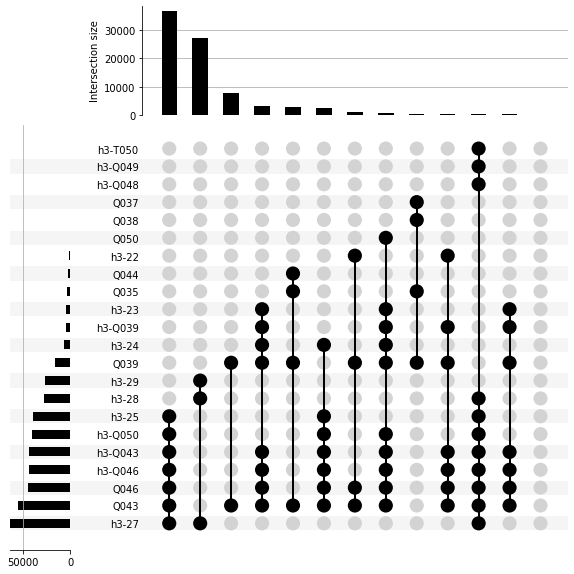

In [10]:
def plot_supported_protocols(protocols, min_urls: int = 100):
    """Plot the sets of supported protocols by their frequency."""
    membership = upsetplot.from_memberships(protocols)
    
    # Compute the size of each set_size subset and filter to the most common
    membership = membership.groupby(membership.index.names).size()
    membership = membership[membership >= min_urls]
    
    # Remove protocols which are no longer represented in the filtered set
    is_represented = membership.index.to_frame().any()
    absent_protos = is_represented[is_represented == False].index.values
    membership = membership.reset_index(level = list(absent_protos), drop = True)
    
    figure = plt.figure(figsize=(10, 10))
    upsetplot.plot(membership, fig=figure, sort_by="cardinality", element_size=None)
    return figure, membership

# Note that the counts for the individuals is reduced since we truncate the dataset
figure, result = plot_supported_protocols(reduced_domains["protocols"])

In [11]:
def rank_protocol_combinations(protocols, min_support: float, n_protocols: int = 3):
    """Determine the protocol combinations that are popular on a reduced set urls.
    
    Domains such as blogspot and appspot which may heavily bias the dataset are reduced 
    before ranking the protocol combinations.
    """
    result = [(entry.support, entry.items) for entry in 
              apriori(list(protocols), min_support=min_support)
              if len(entry.items) >= n_protocols]
    return result

def _filter_rankings(rankings):
    # Sort the rankings primarily by support, then by length.
    # Since python's sort is stable, first sorting by length then rankings 
    # will keep the longer sets first.
    rankings = sorted(rankings, key=lambda x: len(x[1]), reverse=True)
    rankings = sorted(rankings, key=lambda x: x[0], reverse = True)
    
    # Remove sets which are already contained in a set with higher support
    filtered_rankings = []
    
    for support, protocols in rankings:
        to_filter = False

        for _, previously_seen in filtered_rankings:
            if protocols.issubset(previously_seen):
                to_filter = True
                break
        if not to_filter:
            filtered_rankings.append((support, protocols))
    return filtered_rankings

rankings = _filter_rankings(rank_protocol_combinations(reduced_domains["protocols"], .05, 3))

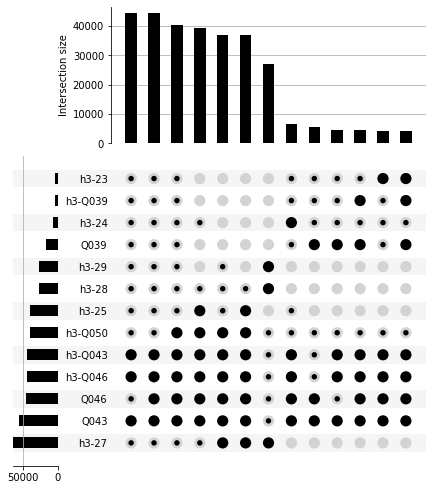

In [12]:
def occuring_with(protocol_sets, rankings):
    columns = set()
    for _, ranked_subset in rankings:
        columns.update(ranked_subset)

    presence = protocol_sets.index.to_frame().reset_index(drop=True)[list(columns)]
    results = []
    
    for _, ranked_subset in rankings:
        mask = np.ones_like(presence.index, dtype=bool)
        for proto in ranked_subset:
            mask = np.logical_and(mask, presence[proto])
        results.append(presence[mask].any())
    return pd.DataFrame(results)

def _plot_non_exclusive_members(ax, plotter, total_data, rankings):
    data = plotter.intersections
    n_cats = data.index.nlevels
    other_memberships = occuring_with(total_data, rankings)

    idx = np.flatnonzero(other_memberships[data.index.names].values)
    colors = np.array(['lightgrey'] * len(data) * n_cats, dtype='O')
    colors[idx] = plotter._facecolor
    x = np.repeat(np.arange(len(data)), n_cats)
    y = np.tile(np.arange(n_cats), len(data))
    ax.scatter(*plotter._swapaxes(x, y), c=colors.tolist(), linewidth=0, s=30)
    

def plot_rankings(rankings, protocols):
    membership = [subset for _, subset in rankings]
    membership_counts = [support * len(protocols) for support, _ in rankings]
    data = upsetplot.from_memberships(membership, data=membership_counts)
    total_data = upsetplot.from_memberships(protocols)
    
    plotter = upsetplot.UpSet(data, sort_by="cardinality", with_lines=False)
    # Correct the totals for each protocol as the rankings come from the 
    # apriori algorithm resulting in non-unique subsets 
    true_totals = (upsetplot.UpSet(total_data, subset_size="count")
                   .totals
                   .loc[plotter.totals.index]
                   .sort_values(ascending=False))
    plotter.totals = true_totals
    # Reorder the matrix labels as well since the totals are labelled by them
    plotter.intersections = plotter.intersections.reorder_levels(true_totals.index.values)
    
    figure = plt.figure()
    axes = plotter.plot(fig=figure)
    _plot_non_exclusive_members(axes["matrix"], plotter, total_data, rankings)
    
    return figure

# TODO: Add the maybe dots to any cell that may be in the intersection
# Look at all the samples. If there is any protocol that is true for an element
# in an intersection below, then that protocol should be a small dot for the
# intersection
figure = plot_rankings(rankings, reduced_domains["protocols"])

if OUTPUT_FILES is not None:
    figure.savefig(OUTPUT_FILES.rankings_plot, bbox_inches='tight', dpi=150)

In [13]:
def select_protocols(rankings, min_protocols: int = 3) -> set:
    """Select the first (highest) ranking with at least 3 protocols 
    starting with h3-, h3-Q, Q*, or otherwise.
    """
    for support, protocols in rankings:
        n_http3_quic = sum(p.startswith("h3-Q") for p in protocols)
        n_http3_ietf = sum(p.startswith("h3-") for p in protocols) - n_http3_quic
        n_quic = sum(p.startswith("Q") for p in protocols)
        assert n_http3_ietf + n_http3_quic + n_quic == len(protocols)
        if any(x >= min_protocols for x in (n_http3_ietf, n_http3_quic, n_quic )):
            return protocols
    return None

In [14]:
def filter_by_protocol(protocols, desired_protocols):
    query_string = " & ".join(desired_protocols)
    data = upsetplot.from_memberships(protocols).to_frame().reset_index()
    
    # Query the data for rows which support the desired protocols
    # Replace '-' as query doesnt work otherwise
    data.columns = [name.replace("-", "_") for name in data.columns]
    return data.query(query_string.replace("-", "_")).index.values
    
selected_protocols = select_protocols(rankings)
assert select_protocols is not None

selected_entries = unique_domains.iloc[filter_by_protocol(unique_domains["protocols"], selected_protocols)]
selected_entries

if OUTPUT_FILES is not None:
    from pathlib import Path
    Path(OUTPUT_FILES.urls_with_version).write_text("# URLs supporting: " + ",".join(selected_protocols) + "\n")
    selected_entries['url'].to_csv(OUTPUT_FILES.urls_with_version, header=False, index=False, mode="a")